# Portugal -- SIR like models

This notebook contains all the Julia 1.4.x code required to characterize the 
propagation of CoViD19 as discussed in the main notebook:
 _Population_dynamics.ipynb_

Here we use _SIR_ like models, that characterize the spread of CoViD19 by
accommodating decay mechanism which account for recovery and death.

### Initialization, display LOAD_PATH at the end

In [1]:
push!(LOAD_PATH, pwd())
if ispath( pwd()*"/src")
    push!(LOAD_PATH, pwd()*"/src")
end


using SpecialFunctions, LaTeXStrings
using DataFrames, Query, CSV
using Dates

using Optim, DifferentialEquations, DiffEqParamEstim


using Plots

theme( :gruvbox_light );
mysize = ( Int( round( 400 *MathConstants.golden ) ), 400 );


# load my functions
using MyFunctions, Mrate

┌ Info: Precompiling Mrate [top-level]
└ @ Base loading.jl:1260


### Parametrization for the incubation times, source:
https://doi.org/10.2807/1560-7917.ES.2020.25.5.2000062

In [2]:
μΓ, σΓ = 6.5, 2.6;      # mean and standard deviation for incubation

αΓ( μ, σ ) = μ^2/σ^2;   # [α] = 1  is a dimensionless parameter
βΓ( μ, σ ) = μ / σ^2    # [β] = 1/T has dimension of frequency

α0 = αΓ( μΓ, σΓ );
β0 = βΓ( μΓ, σΓ );

ρ0=[α0,β0];

### load data and manipulate data

In [3]:
path = pwd()*"/datahub.io/covid-19/data";
path_data = path*"/time-series-19-covid-combined.csv";
path_ref  = path*"/reference.csv";

raw_data = CSV.File( path_data ) |> DataFrame!;
col_names = names( raw_data )

col_names[2] = "CountryRegion";
col_names[3] = "ProvinceState";
rename!( raw_data, col_names );

In [4]:
country_names =  unique( raw_data[!,2] );
country_name = "Portugal";
country = raw_data |> @filter( _.CountryRegion==country_name
    ) |> DataFrame;

In [5]:
dates = Date.( country[!,:Date] );

confirmed_int = convert( Array{Number}, country[!,:Confirmed] );
recovered_int = convert( Array{Number}, country[!,:Recovered] );
deaths_int    = convert( Array{Number}, country[!,:Deaths   ] );

In [6]:
d1   = findfirst( >=(1  ), confirmed_int );
d10  = findfirst( >=(10 ), confirmed_int );
d20  = findfirst( >=(20 ), confirmed_int );
d50  = findfirst( >=(50 ), confirmed_int );
d100 = findfirst( >=(100), confirmed_int );

read raw data and basic processing

In [7]:
raw_ref  = CSV.File( path_ref  ) |> DataFrame!;
ref_names = names( raw_ref )

IDs = convert( Vector, raw_ref[!,11] );

row_country = findall( isequal( country_name ), IDs );
@assert length( row_country ) == 1
population = convert.( Number, raw_ref[ row_country[1], 12 ] );

println( [ population, 1/population ]' )

[1.0196707e7 9.807087719594178e-8]


In [8]:
#   set initial time and offset it to day of first registered infection
date_1 = dates[ d1 ]
data_last = dates[ end ]
days = float.( Dates.value.( dates -date_1 ) )

# normalize population
confirmed = confirmed_int ./ population;
recovered = recovered_int ./ population;
deaths    = deaths_int    ./ population;

# determine normalized sir time series
removed     = ( recovered +deaths  );
infected    = ( confirmed -removed );
susceptible = ( 1 .-infected .-removed );

#### visualize raw data

In [26]:
nM = 1.05 *maximum( confirmed )
nm = 0.75 *minimum( confirmed )


tm, tM = days[d1], maximum( days ) +5;

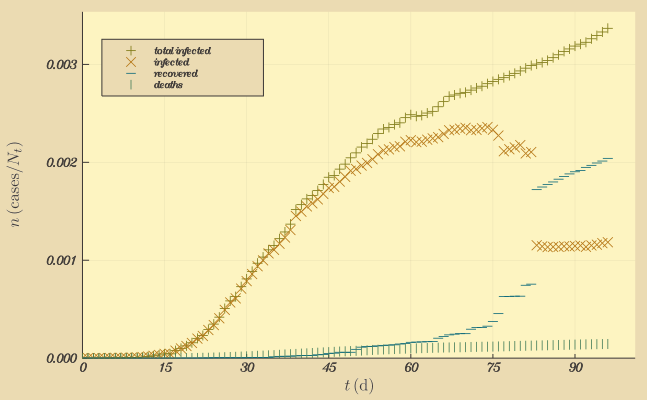

In [27]:
plot( days, confirmed, label="total infected"
    , shape=:cross, msize=5, lα=0
    , xlabel = L"t \, \mathrm{(d)}", xlims = (0,tM), xticks = 0:15:tM
    , ylabel = L"n \, (\mathrm{cases}/N_t)", ylims = (-500*nm,nM)
    , legend=:topleft, legendfontsize=6, size=mysize )
plot!( days, infected, label="infected"
    , markershape=:xcross, markersize=5, linealpha=0 )
plot!( days, recovered, label="recovered"
    , markershape=:hline, markersize=5, linealpha=0 )
plot!( days, deaths, label="deaths"
    , markershape=:vline, markersize=5, linealpha=0 )

### Note the large jump at  t=83

On this day, 2020-05-24, the Portuguese authorities change the criteria that 
defined the transition from infected to recovered status, leading to a large 
conversion of infected to recovered cases.

This in criteria breaks the characterization of the infected and recovered time 
series. Therefore, from this date onwards, we shall split our analysis into two 
parts. The former contains data up to 2020-05-23, while the latter contains 
data from 2020-05-24 onwards.

Consider the following reports in the Portuguese press
[Público](https://www.publico.pt/2020/05/24/sociedade/noticia/nova-contagem-casos-traz-recorde-recuperados-covid19-1917895)
and
[Sabado](https://www.sabado.pt/portugal/detalhe/covid-19-numero-de-recuperados-vai-disparar-avisa-ministra).

In [18]:
t_break_1 = findfirst( ==(Dates.Date("2020-05-24")), dates )
dates[ t_break_1 ]

2020-05-24

### SIR-like models (up to 2020-05-23)

#### Susceptible, infected and removed

In [11]:
# ------------------------------------ #
#
#   SIR-like model is available from Mrate.jl
#   
#   sir_Γ! ≡ differential equation with respect to:,
#            1 -susceptible
#            infected
#            removed
#   
#   sidr_Γ! ≡ differential equation with respect to:,
#            1 -susceptible
#            infected
#            recovered
#            deceased


# ------------------------------------ #
# 
#   initialization values and test run
#
du0 = zeros(3); u0 = [ 1e-7, 1e-7, 0. ]; t0 = 1.0;

p0 = [ 0.26, 0.01, 34.9 ]; νμ0 = 1/21.0; ρ0 = [ 6.25, 0.96 ];

println( sir_Γ!(du0,u0,t0; p=p0, ν=νμ0, ρ=ρ0) )

# ------------------------------------ #
# 
# the Optim.optimize routine requires an optimization function that takes a
# single entry of parameters p, to facilitate this we define 
# 
function SIR!( du,u,p,t )
    sir_Γ!( du,u,t; p=p[1:end-1], ν=p[end], ρ=ρ0)
end

append!( p0, νμ0 )
println( SIR!( du0,u0,p0,1.0 ) )

4.761904761904761e-9
4.761904761904761e-9


In [19]:
# ------------------------------------ #
# 
#   make an unified data array
#
data_0 = zeros(3,length(infected))
data_0[1,:] = 1.0 .-susceptible
data_0[2,:] = 1.0 .*infected
data_0[3,:] = 1.0 .*removed

#   initialization values and test run
#
d_ini = d50
#d_end = length(infected)
d_end = t_break_1 -1

data = data_0[:,d_ini:d_end]
days_t = days[d_ini:d_end]

u0 = data[:,1]
tspan = (days_t[1],days_t[end] )
du0 = similar( u0 )


p1 = [ 0.26, 0.01, 34.9 ]; append!( p1, νμ0 )
p2 = [ 0.26, 0.01, 34.9, 0.00183, 66.4 ]; append!( p2, νμ0 )
p3 = [ 0.1, 0.04, 24.6, 0.02, 50.0, 0.02, 80 ]; append!( p3, νμ0 )

p0 = p3; println( round.( p0; sigdigits=3 ) )

[0.1, 0.04, 24.6, 0.02, 50.0, 0.02, 80.0, 0.0476]


##### Define the differential equation problem, optimize and solve it with optimal parameters

In [20]:
#   define the ODE problem and cost function using:
#       DifferentialEquations.jl
#       DiffEqParamEstim.jl
#
prob = ODEProblem(SIR!,u0,tspan,p0)

cost = build_loss_objective( prob, Tsit5(), L2Loss(days_t,data),
    abstol = 1e-12, reltol = 1e-12, verbose = false)

println( "\np0 and minimizers for prob_0 and prob" )
println( round.( p0; sigdigits=3 ) )


p0 and minimizers for prob_0 and prob
[0.1, 0.04, 24.6, 0.02, 50.0, 0.02, 80.0, 0.0476]


In [21]:
#   optimize parameters via Optim.jl with different algorithms

result_0 = Optim.optimize( cost, p0, NelderMead() )
println( string( round.( result_0.minimizer; sigdigits=3 )
    )*" Converged: "*string( Optim.converged( result_0 ) )  )

result   = Optim.optimize( cost, p0, BFGS() )
println( string( round.( result.minimizer; sigdigits=3 )
    )*" Converged: "*string( Optim.converged( result ) )  )

[0.226, 0.0509, 26.3, 0.0551, 28.7, 0.0124, 37.9, 0.0061] Converged: true
[0.265, 0.0438, 22.0, 0.00927, 44.7, -0.141, 80.0, 0.00614] Converged: true


In [22]:
#   integrate the differential equations with optimal parameters
#
prob_opt_0 = ODEProblem( SIR!, u0, tspan, result_0.minimizer, saveat=1 );
sol_opt_0 = solve(prob_opt_0,Tsit5());
prob_opt = ODEProblem( SIR!, u0, tspan, result.minimizer, saveat=1 );
sol_opt = solve(prob_opt,Tsit5());

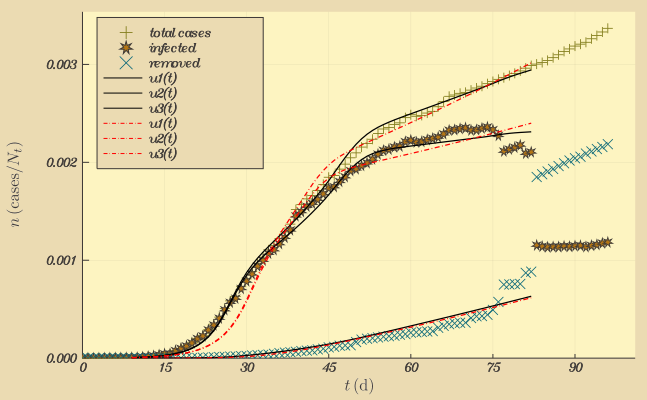

In [28]:
plot(days,confirmed,label="total cases", shape=:cross, msize=5, lα=0)
plot!(days,infected,label="infected", shape=:star7 , msize=5, lα=0)
plot!(days,removed ,label="removed" , shape=:xcross, msize=5, lα=0)

plot!( sol_opt, lcolor=:black, width=1.25 )
plot!( sol_opt_0, style=:dashdot, lcolor=:red, width=1.25 )

plot!( xlabel = L"t \, \mathrm{(d)}", xlims = (0,tM), xticks = 0:15:tM
    , ylabel = L"n \, (\mathrm{cases}/N_t)", ylims = (nm,nM)
    , legend=(.12,.94), size=mysize )

In [29]:
savefig("img/"*country_name*"_SIR_truncated.svg")


println( result_0.minimum )
println( result.minimum )

2.2615595049149816e-6
9.804769677182257e-7


#### Susceptible, infected, recovered and deceased

In [30]:
du0 = zeros(4); u0 = [ 1e-7, 1e-7, 0., 0. ]; t0 = 1.0;

p0 = [ 0.26, 0.01, 34.9 ]; νμ0 = [ 1/21.0, 0.5/21 ]; ρ0 = [ 6.25, 0.96 ];

println( sird_Γ!(du0,u0,t0; p=p0, νμ=νμ0, ρ=ρ0) )

function SIRD!( du,u,p,t )
    sird_Γ!( du,u,t; p=p[1:end-2], νμ=p[end-1:end], ρ=ρ0)
end
append!( p0, νμ0 )
println( SIRD!( du0,u0,p0,t0 ) )

2.3809523809523806e-9
2.3809523809523806e-9


In [31]:
# ------------------------------------ #
# 
#   make an unified data array
#
data_0 = zeros(4,length(infected))
data_0[1,:] = 1.0 .-susceptible
data_0[2,:] = 1.0 .*infected
data_0[3,:] = 1.0 .*recovered
data_0[4,:] = 1.0 .*deaths

#   initialization values and test run
#
#
d_ini = d20
# d_end = length(infected)
d_end = t_break_1 -1
data = data_0[:,d_ini:d_end]
days_t = days[d_ini:d_end]

u0 = data[:,1]
tspan = (days_t[1],days_t[end] )
du0 = similar( u0 )


τr =21; rr = 1/τr
νμ0 = [ rr, rr/10 ]
# τr =29; rr = 1/τr

p3 = [ 0.1, 0.04, 24.6, 0.02, 50.0, 0.02, 80 ]; append!( p3, νμ0 )

p0 = p3; println( round.( p0; sigdigits=3 ) )

[0.1, 0.04, 24.6, 0.02, 50.0, 0.02, 80.0, 0.0476, 0.00476]


##### Define the differential equation problem, optimize and solve it with optimal parameters

In [32]:
prob = ODEProblem(SIRD!,u0,tspan,p0);

cost = build_loss_objective( prob  , Tsit5(), L2Loss(days_t,data),
    abstol = 1e-16, reltol = 1e-16, verbose = true);

println( "\np0 and minimizers for prob_0 and prob" )
println( round.( p0; sigdigits=3 ) )


p0 and minimizers for prob_0 and prob
[0.1, 0.04, 24.6, 0.02, 50.0, 0.02, 80.0, 0.0476, 0.00476]


In [42]:
res0 = Optim.optimize(cost, p0, NelderMead() )
println( string( round.( res0.minimizer; sigdigits=3 )
    )*" Converged: "*string( Optim.converged( res0 ) )  )
prob_opt_0 = ODEProblem( SIRD!, u0, tspan, res0.minimizer, saveat=1 );
sol_opt_0  = solve(prob_opt_0,Tsit5());

res1 = Optim.optimize(cost, p0, BFGS() )
println( string( round.( res1.minimizer; sigdigits=3 )
    )*" Converged: "*string( Optim.converged( res1 ) )  )
prob_opt_1 = ODEProblem( SIRD!, u0, tspan, res1.minimizer, saveat=1 );
sol_opt_1  = solve(prob_opt_1,Tsit5());

[0.243, 0.173, 23.2, 0.016, 28.3, 0.0751, 79.3, 0.00462, 0.00157] Converged: true
[0.268, 0.044, 21.9, 0.00927, 44.7, -0.133, 80.0, 0.0046, 0.00153] Converged: true


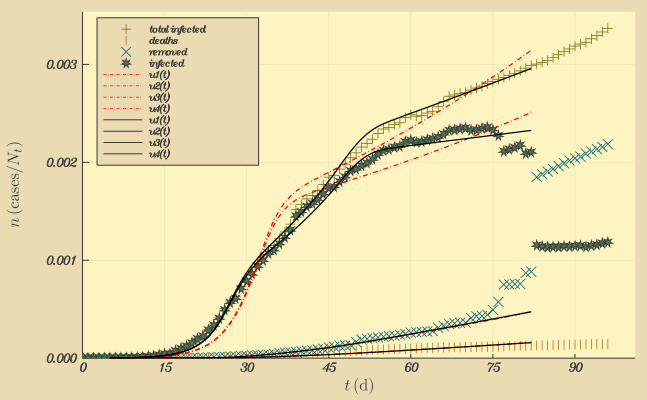

In [43]:
plot(days,confirmed,label="total infected",shape=:cross,msize=5,lα=0)
plot!(days,deaths  ,label="deaths"  ,shape=:vline ,msize=5,lα=0)
plot!(days,removed ,label="removed" ,shape=:xcross,msize=5,lα=0)
plot!(days,infected,label="infected",shape=:star7 ,msize=5,lα=0)


plot!( sol_opt_0, style=:dashdot, lcolor=:red, width=1.25 )
plot!( sol_opt_1, lcolor=:black, width=1.25 )

plot!( xlabel = L"t \, \mathrm{(d)}", xlims = (0,tM), xticks = 0:15:tM
    , ylabel = L"n \, (\mathrm{cases}/N_t)", ylims = (-500*nm,nM)
    , legend=(.12,.95), legendfontsize=6, size=mysize )

In [44]:
println( round.( 1 ./ res1.minimizer[end-1:end]; sigdigits=3 ) )

[217.0, 652.0]
